In [1]:
import os
import sys
import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML
from sklearn.datasets import load_iris
from pystout import pystout
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Global Settings
pd.set_option("display.float_format", lambda x: "%.4f" % x)


# weighting

# Add weighting logic here

In [3]:
cwd = os.getcwd()
# Find and import config file
config_path = os.getcwd()

sys.path.append(config_path)
import config

database = config.database
central_banks = config.central_banks
training_data = os.path.join(database, "Training Data")
fed_docs = config.fed_docs
ecb_docs = config.ecb_docs
boe_docs = config.boe_docs

In [4]:
test = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor.csv"
)

In [5]:
sentiment = pd.date_range(start="1/1/1990", end="12/31/2024", freq="D")
sentiment = pd.DataFrame(sentiment, columns=["date"])

In [6]:
# Import inflation probability data that is stored as a dta file
inflation_prob_us = pd.read_stata(
    "/Users/kylenabors/Documents/Database/Other Data/Inflation Probabilities/USwestimates.dta"
)

inflation_prob_us = inflation_prob_us.rename(columns={"date_ym": "date"})

inflation_prob_eu = pd.read_stata(
    "/Users/kylenabors/Documents/Database/Other Data/Inflation Probabilities/EZwestimates.dta"
)

inflation_prob_eu = inflation_prob_eu.rename(columns={"date_ym": "date"})

inflation_prob = inflation_prob_us.merge(
    inflation_prob_eu, on="date", how="left", suffixes=("_us", "_eu")
)

sentiment = sentiment.merge(inflation_prob, on="date", how="left")

# sentiment = sentiment.ffill()

In [7]:
inflation_diff = pd.read_excel(
    "/Users/kylenabors/Documents/Database/Market Data/Inflation/12m cumulative inflation.xlsx"
)

print(inflation_diff.dtypes)

sentiment = pd.merge(sentiment, inflation_diff, on="date", how="left")

date               datetime64[ns]
12m_inf                   float64
target_distance           float64
high_inf                  float64
low_inf                   float64
dtype: object


In [8]:
indexes = pd.read_excel(
    "/Users/kylenabors/Documents/Database/Other Data/Indexes/five_indexes.xlsx"
)
indexes["date"] = pd.to_datetime(indexes["date"])
sentiment = pd.merge(sentiment, indexes, how="left", left_on="date", right_on="date")

In [9]:
market = pd.read_csv(f"{database}/Market Data/All Market Data.csv")
market = market.rename(columns={"PCE": "pce", "GDP": "gdp", "GDPPOT": "gdp_pot"})
market["date"] = pd.to_datetime(market["date"])

sentiment = pd.merge(sentiment, market, how="left", left_on="date", right_on="date")

In [ ]:
# # HP Filter


url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

for i in range(len(url_map)):
    temp_dates = pd.date_range(start="1/1/1990", end="12/31/2024", freq="D")
    temp_dates = pd.DataFrame(temp_dates, columns=["date"])
    sent = pd.read_csv(url_map["finbert_url"][i])

    # Adding Weights

    # By word count
    # sent = sent[["date", "sentiment", "weight"]]
    # sent["sentiment"] = sent["sentiment"] * sent["weight"]
    # sent = sent.drop(columns=["weight"])

    # By Length
    sent = sent[["date", "sentiment", "len"]]
    sent["sentiment"] = sent["sentiment"] * sent["len"]
    sent = sent.drop(columns=["len"])

    sent = sent[["date", "sentiment"]]

    sent["date"] = pd.to_datetime(sent["date"])
    sent = sent.groupby("date").mean().reset_index()

    sent = pd.merge(temp_dates, sent, how="left", left_on="date", right_on="date")

    # Set 'date' as the index for resampling
    sent.set_index("date", inplace=True)

    sent["sentiment"] = sent["sentiment"].ffill()

    # Resample to quarterly frequency
    sent = sent.resample("Q").mean()

    # Drop NaNs
    sent = sent.dropna(subset=["sentiment"])

    # Reset index to turn 'date' back into a column
    sent.reset_index(inplace=True)

    filter_df = sent.copy(deep=True)

    cycle, trend = sm.tsa.filters.hpfilter(filter_df["sentiment"], 1600)

    filter_df["sentiment_cycle"] = cycle
    filter_df["sentiment_trend"] = trend

    filter_df = filter_df[["date", "sentiment_cycle"]]
    sent = sent.drop(columns=["sentiment"])
    filter_df = filter_df.rename(columns={"sentiment_cycle": "sentiment"})
    sent = pd.merge(sent, filter_df, on="date", how="outer")
    sent = sent.groupby("date").mean().reset_index()

    sent = sent.rename(columns={"sentiment": url_map["document"][i]})
    sentiment = pd.merge(sentiment, sent, how="outer", left_on="date", right_on="date")

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_54227/3436836574.py:37: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sent = sent.resample("Q").mean()
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_54227/3436836574.py:37: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sent = sent.resample("Q").mean()
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_54227/3436836574.py:37: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sent = sent.resample("Q").mean()
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_54227/3436836574.py:37: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sent = sent.resample("Q").mean()
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_54227/3436836574.py:37: FutureWarning: 'Q' is deprecated and will be remo

In [11]:
fedfunds = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Market Data/Fed Funds/Fed Funds.csv"
)
fedfunds["date"] = pd.to_datetime(fedfunds["date"])
sentiment = pd.merge(sentiment, fedfunds, how="left", left_on="date", right_on="date")

In [12]:
stocks = sentiment.copy(deep=True)
stocks = stocks[["date", "sp500_return", "stoxx"]]
stocks["log_returns"] = np.log(1 + stocks["sp500_return"])
stocks["log_returns_eu"] = np.log(1 + stocks["stoxx"])
stocks = stocks.resample("Q", on="date").sum().reset_index()

for i in range(0, 6):
    stocks[f"log_returns_{i}"] = stocks["log_returns"].shift(i)
    stocks[f"log_returns_eu_{i}"] = stocks["log_returns_eu"].shift(i)

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_54227/1053901969.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  stocks = stocks.resample("Q", on="date").sum().reset_index()


In [13]:
# Resample the final 'sentiment' DataFrame to quarterly frequency
sentiment = sentiment.drop(columns=["sp500_return", "stoxx"])
sentiment = sentiment.resample("Q", on="date").mean().reset_index()

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_54227/4229648175.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sentiment = sentiment.resample("Q", on="date").mean().reset_index()


In [14]:
# merging FSI data
sentiment["fsi"] = (
    sentiment["credit"]
    + sentiment["equity_valuation"]
    + sentiment["safe_assets"]
    + sentiment["funding"]
    + sentiment["volatility"]
)

In [15]:
# Create lagged columns
for column in sentiment.columns:
    if column != "date":  # Skip the 'date' column
        sentiment[f"{column}_1"] = sentiment[column].shift(1)

for i in range(1, 5):
    sentiment[f"fed_minutes_forward_{i}"] = sentiment["fed_minutes"].shift(-i)
    sentiment[f"fed_minutes_lag_{i}"] = sentiment["fed_minutes"].shift(i)
    sentiment[f"press_conferences_forward_{i}"] = sentiment["press_conferences"].shift(
        -i
    )
    sentiment[f"credit_lag_{i}"] = sentiment["credit"].shift(i)
    sentiment[f"equity_valuation_lag_{i}"] = sentiment["equity_valuation"].shift(i)
    sentiment[f"safe_assets_lag_{i}"] = sentiment["safe_assets"].shift(i)
    sentiment[f"funding_lag_{i}"] = sentiment["funding"].shift(i)
    sentiment[f"volatility_lag_{i}"] = sentiment["volatility"].shift(i)
    sentiment[f"fsi_lag_{i}"] = sentiment["fsi"].shift(i)

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_54227/2749734380.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment[f"fsi_lag_{i}"] = sentiment["fsi"].shift(i)
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_54227/2749734380.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment[f"fed_minutes_forward_{i}"] = sentiment["fed_minutes"].shift(-i)
/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_54227/2749734380.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [16]:
sentiment = pd.merge(sentiment, stocks, how="left", left_on="date", right_on="date")

In [17]:
# sentiment = sentiment[
#     (sentiment["date"] >= "2000-01-01") & (sentiment["date"] <= "2023-01-30")
# ]

sentiment = sentiment[
    (sentiment["date"] >= "2000-06-01") & (sentiment["date"] <= "2022-06-30")
]

In [18]:
# Export sentiment as csv
sentiment.to_csv(f"{database}/Sentiment.csv", index=False)

In [19]:
print(sentiment.columns)

Index(['date', 'date_stata_us', 'higher4_5y5y_us', 'higher5_5y5y_us',
       'lower0_5y5y_us', 'lowerm1_5y5y_us', 'zc_higher4_5y_us',
       'zc_higher5_5y_us', 'zc_lower0_5y_us', 'zc_lowerm1_5y_us',
       ...
       'log_returns_1', 'log_returns_eu_1', 'log_returns_2',
       'log_returns_eu_2', 'log_returns_3', 'log_returns_eu_3',
       'log_returns_4', 'log_returns_eu_4', 'log_returns_5',
       'log_returns_eu_5'],
      dtype='object', length=191)


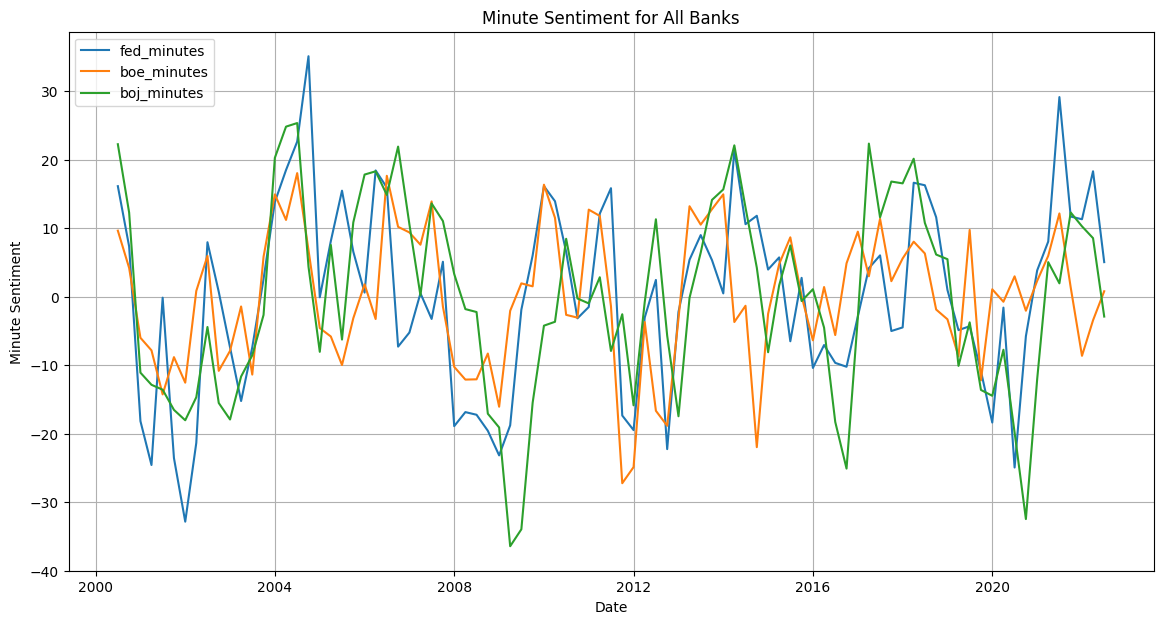

In [20]:
import matplotlib.pyplot as plt

# List of columns containing minute sentiment for all banks
minute_sentiment_columns = [
    "fed_minutes",
    "ecb_minutes",
    "boe_minutes",
    "boj_minutes",
    "boa_minutes",
    "boc_minutes",
    "boswiss_minutes",
    "bosweaden",
]

# Plotting the minute sentiment for all banks
plt.figure(figsize=(14, 7))

for column in minute_sentiment_columns:
    if column in sentiment.columns:
        plt.plot(sentiment["date"], sentiment[column], label=column)

plt.xlabel("Date")
plt.ylabel("Minute Sentiment")
plt.title("Minute Sentiment for All Banks")
plt.legend()
plt.grid(True)
plt.show()

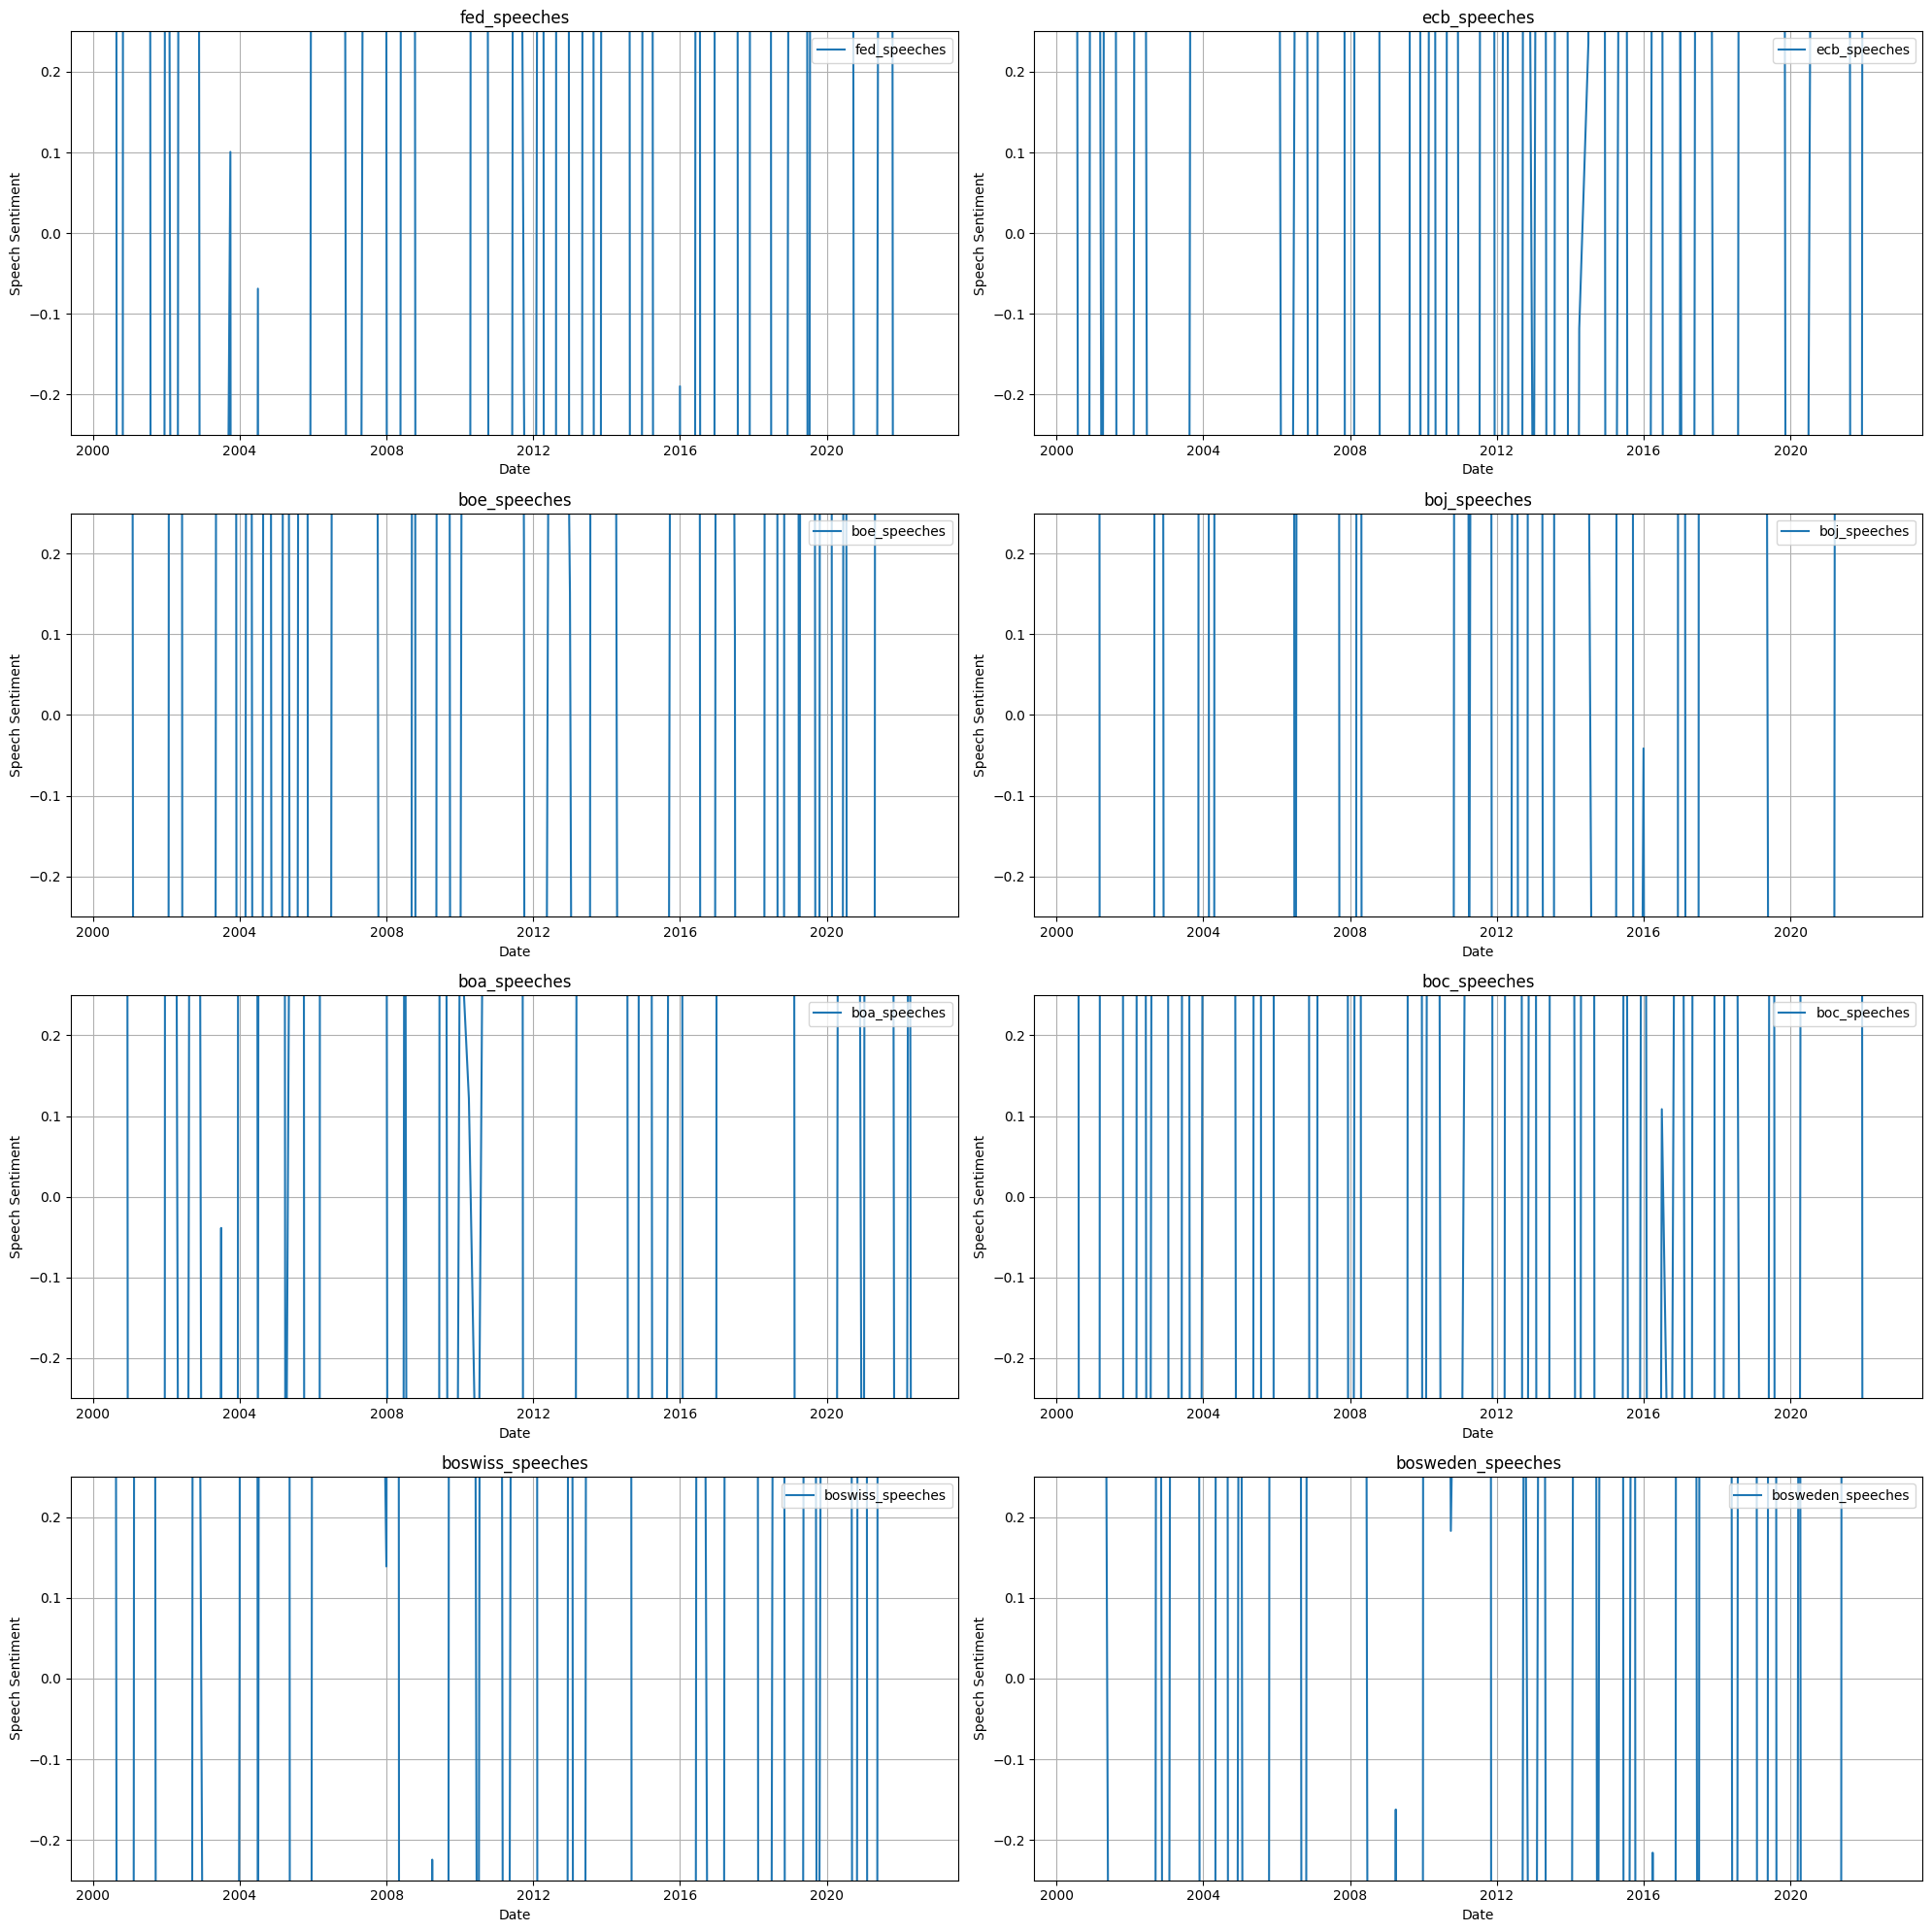

In [21]:
# List of columns containing speech sentiment for all banks
speech_sentiment_columns = [
    'fed_speeches', 
    'ecb_speeches', 
    'boe_speeches', 
    'boj_speeches', 
    'boa_speeches', 
    'boc_speeches', 
    'boswiss_speeches', 
    'bosweden_speeches',
]

# Define the layout of the subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each sentiment column in its own subplot
for i, column in enumerate(speech_sentiment_columns):
    if column in sentiment.columns:
        axes[i].plot(sentiment['date'], sentiment[column], label=column)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Speech Sentiment')
        axes[i].set_title(column)
        axes[i].set_ylim(-0.25, 0.25)  # Set y-axis limits
        axes[i].legend()
        axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [22]:
# Table 3 Pt. 1

x = [
    "press_conferences",
    "press_conferences_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Variables")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "press_conferences",
        "press_conferences_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "press_conferences": "ECB Sent (t)",
        "press_conferences_1": "ECB Sent (t-1)",
        "fed_minutes_1": "Fed Sent (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 ECB Sent (t) & 0.271$^{***}$ & 0.244$^{**}$ & 0.057$^{}$ & 0.086$^{}$ & -0.151$^{}$ \\
& (0.093) & (0.100) & (0.088) & (0.089) & (0.093) \\
 ECB Sent (t-1) & -0.209$^{**}$ & -0.311$^{***}$ & -0.297$^{***}$ & -0.464$^{***}$ & -0.256$^{***}$ \\
& (0.096) & (0.086) & (0.089) & (0.099) & (0.099) \\
 Fed Sent (t-1) & 0.562$^{***}$ & 0.297$^{***}$ & 0.261$^{***}$ & 0.245$^{***}$ & 0.034$^{}$ \\
& (0.101) & (0.091) & (0.101) & (0.092) & (0.086) \\
\hline \
 Observations & 89 & 89 & 89 & 89 & 89 \\
 $R^2$ & 0.385 & 0.148 & 0.115 & 0.228 & 0.190 \\
 Adjusted $R^2$ & 0.364 & 0.118 & 0.083 & 0.201 & 0.161 \\
 Residual Std. Error & 10.844 (df=85

In [23]:
# Table 3 Pt. 2

x = [
    "fed_minutes",
    "fed_minutes_1",
    "press_conferences_1",
]

yvar0 = "press_conferences"
yvar1 = "press_conferences_forward_1"
yvar2 = "press_conferences_forward_2"
yvar3 = "press_conferences_forward_3"
yvar4 = "press_conferences_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Variables")
stargazer.custom_columns(
    [
        "ECB Sent. (t)",
        "ECB Sent. (t+1)",
        "ECB Sent. (t+2)",
        "ECB Sent. (t+3)",
        "ECB Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "fed_minutes",
        "fed_minutes_1",
        "press_conferences_1",
    ]
)

stargazer.rename_covariates(
    {
        "fed_minutes": "Fed Sent (t)",
        "fed_minutes_1": "Fed Sent (t-1)",
        "press_conferences_1": "ECB Sent (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{ECB Sent. (t)} & \multicolumn{1}{c}{ECB Sent. (t+1)} & \multicolumn{1}{c}{ECB Sent. (t+2)} & \multicolumn{1}{c}{ECB Sent. (t+3)} & \multicolumn{1}{c}{ECB Sent. (t+4)}  \\
\hline \
 Fed Sent (t) & 0.355$^{***}$ & 0.250$^{}$ & 0.169$^{}$ & 0.190$^{}$ & 0.030$^{}$ \\
& (0.119) & (0.153) & (0.144) & (0.134) & (0.158) \\
 Fed Sent (t-1) & -0.147$^{}$ & -0.022$^{}$ & 0.036$^{}$ & 0.021$^{}$ & 0.239$^{*}$ \\
& (0.118) & (0.150) & (0.144) & (0.172) & (0.137) \\
 ECB Sent (t-1) & 0.608$^{***}$ & 0.256$^{***}$ & 0.143$^{}$ & -0.044$^{}$ & -0.221$^{*}$ \\
& (0.071) & (0.097) & (0.108) & (0.128) & (0.124) \\
\hline \
 Observations & 89 & 89 & 89 & 89 & 89 \\
 $R^2$ & 0.435 & 0.121 & 0.056 & 0.028 & 0.065 \\
 Adjusted $R^2$ & 0.416 & 0.090 & 0.023 & -0.006 & 0.032 \\
 Residual Std. Error & 12.416 (df=85) & 15.341 (df=85) & 

In [24]:
# # Define the independent variables for each regression
# x = ["fed_minutes", "fed_minutes_1", "fedfunds_1"]

# yvar0 = "fedfunds"
# yvar1 = "fedfunds_forward_1"
# yvar2 = "fedfunds_forward_2"
# yvar3 = "fedfunds_forward_3"
# yvar4 = "fedfunds_forward_4"


# # Prepare the exogenous variables for each regression
# exog0 = sm.add_constant(sentiment[x]).dropna()
# exog1 = sm.add_constant(sentiment[x]).dropna()
# exog2 = sm.add_constant(sentiment[x]).dropna()
# exog3 = sm.add_constant(sentiment[x]).dropna()
# exog4 = sm.add_constant(sentiment[x]).dropna()


# # Fit the regression models
# reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
# reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
# reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
# reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
# reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# # Create the Stargazer object
# stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# # Customize the Stargazer output
# stargazer.show_model_numbers(False)
# stargazer.significant_digits(3)

# # Display the Stargazer output
# display(HTML(stargazer.render_html()))
# print(stargazer.render_latex())

In [25]:
# Fed SR LR ECB SR LR

x0 = [
    "higher4_5y5y_us",
    "higher4_5y5y_us_1",
    "lower0_5y5y_us",
    "lower0_5y5y_us_1",
    "fed_minutes_1",
]

x1 = [
    "zc_higher4_5y_us",
    "zc_higher4_5y_us_1",
    "zc_lower0_5y_us",
    "zc_lower0_5y_us_1",
    "fed_minutes_1",
]

x2 = [
    "higher4_5y5y_eu",
    "higher4_5y5y_eu_1",
    "lower0_5y5y_eu",
    "lower0_5y5y_eu_1",
    "press_conferences_1",
]

x3 = [
    "zc_higher4_5y_eu",
    "zc_higher4_5y_eu_1",
    "zc_lower0_5y_eu",
    "zc_lower0_5y_eu_1",
    "press_conferences_1",
]


yvar = "fed_minutes"
yvar1 = "fed_minutes"
yvar2 = "press_conferences"
yvar3 = "press_conferences"

exog0 = (sm.add_constant(sentiment[x0])).dropna()
exog1 = (sm.add_constant(sentiment[x1])).dropna()
exog2 = (sm.add_constant(sentiment[x2])).dropna()
exog3 = (sm.add_constant(sentiment[x3])).dropna()

reg0 = sm.OLS(endog=sentiment[yvar].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")

stargazer = Stargazer([reg0, reg1, reg2, reg3])
stargazer.title(
    "Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns"
)
stargazer.custom_columns(["SR Fed(t)", "LR Fed(t)", "SR ECB(t)", "LR ECB(t)"])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.covariate_order(
    [
        "higher4_5y5y_us",
        "higher4_5y5y_us_1",
        "lower0_5y5y_us",
        "lower0_5y5y_us_1",
        "zc_higher4_5y_us",
        "zc_higher4_5y_us_1",
        "zc_lower0_5y_us",
        "zc_lower0_5y_us_1",
        "higher4_5y5y_eu",
        "higher4_5y5y_eu_1",
        "lower0_5y5y_eu",
        "lower0_5y5y_eu_1",
        "zc_higher4_5y_eu",
        "zc_higher4_5y_eu_1",
        "zc_lower0_5y_eu",
        "zc_lower0_5y_eu_1",
        "fed_minutes_1",
        "press_conferences_1",
    ]
)
stargazer.rename_covariates(
    {
        "higher4_5y5y_us": "Inflation(t)",
        "higher4_5y5y_us_1": "Inflation(t-1)",
        "lower0_5y5y_us": "Deflation(t)",
        "lower0_5y5y_us_1": "Deflation(t-1)",
        "zc_higher4_5y_us": "Inflation(t)",
        "zc_higher4_5y_us_1": "Inflation(t-1)",
        "zc_lower0_5y_us": "Deflation(t)",
        "zc_lower0_5y_us_1": "Deflation(t-1)",
        "higher4_5y5y_eu": "Inflation(t)",
        "higher4_5y5y_eu_1": "Inflation(t-1)",
        "lower0_5y5y_eu": "Deflation(t)",
        "lower0_5y5y_eu_1": "Deflation(t-1)",
        "zc_higher4_5y_eu": "Inflation(t)",
        "zc_higher4_5y_eu_1": "Inflation(t-1)",
        "zc_lower0_5y_eu": "Deflation(t)",
        "zc_lower0_5y_eu_1": "Deflation(t)",
        "fed_minutes_1": "Fed(t-1)",
        "press_conferences_1": "ECB(t-1)",
    },
)
stargazer.add_custom_notes(
    [
        "The unit for t is the time between a given meeting and the previous meeting for the given Central Bank."
    ]
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{SR Fed(t)} & \multicolumn{1}{c}{LR Fed(t)} & \multicolumn{1}{c}{SR ECB(t)} & \multicolumn{1}{c}{LR ECB(t)}  \\
\hline \
 Inflation(t) & 19.922$^{}$ & & & \\
& (94.810) & & & \\
 Inflation(t-1) & 93.933$^{}$ & & & \\
& (90.335) & & & \\
 Deflation(t) & -382.295$^{***}$ & & & \\
& (91.656) & & & \\
 Deflation(t-1) & 145.503$^{}$ & & & \\
& (91.854) & & & \\
 Inflation(t) & & 127.168$^{*}$ & & \\
& & (65.841) & & \\
 Inflation(t-1) & & -136.965$^{*}$ & & \\
& & (79.552) & & \\
 Deflation(t) & & -422.986$^{***}$ & & \\
& & (75.477) & & \\
 Deflation(t-1) & & 301.176$^{***}$ & & \\
& & (76.437) & & \\
 Inflation(t) & & & -170.154$^{}$ & \\
& & & (136.764) & \\
 Inflation(t-1) & & & 34.952$^{}$ & \\
& & & (151.109) & \\
 Deflation(t) & & & -145.539$^{*}$ & \\
& & & (79.988) & \\
 

In [26]:
# Fed SR LR ECB SR LR

x0 = [
    "higher4_5y5y_us",
    "higher4_5y5y_us_1",
    "lower0_5y5y_us",
    "lower0_5y5y_us_1",
    "fed_minutes_1",
    "log_returns_0",
    "log_returns_1",
    "log_returns_2",
    "log_returns_3",
    "log_returns_4",
    "log_returns_5",
    "12m_inf",
    "12m_inf_1",
]

x1 = [
    "zc_higher4_5y_us",
    "zc_higher4_5y_us_1",
    "zc_lower0_5y_us",
    "zc_lower0_5y_us_1",
    "fed_minutes_1",
    "log_returns_0",
    "log_returns_1",
    "log_returns_2",
    "log_returns_3",
    "log_returns_4",
    "log_returns_5",
    "12m_inf",
    "12m_inf_1",
]

x2 = [
    "higher4_5y5y_eu",
    "higher4_5y5y_eu_1",
    "lower0_5y5y_eu",
    "lower0_5y5y_eu_1",
    "press_conferences_1",
    "log_returns_eu_0",
    "log_returns_eu_1",
    "log_returns_eu_2",
    "log_returns_eu_3",
    "log_returns_eu_4",
    "log_returns_eu_5",
]

x3 = [
    "zc_higher4_5y_eu",
    "zc_higher4_5y_eu_1",
    "zc_lower0_5y_eu",
    "zc_lower0_5y_eu_1",
    "press_conferences_1",
    "log_returns_eu_0",
    "log_returns_eu_1",
    "log_returns_eu_2",
    "log_returns_eu_3",
    "log_returns_eu_4",
    "log_returns_eu_5",
]


yvar = "fed_minutes"
yvar1 = "fed_minutes"
yvar2 = "press_conferences"
yvar3 = "press_conferences"

exog0 = (sm.add_constant(sentiment[x0])).dropna()
exog1 = (sm.add_constant(sentiment[x1])).dropna()
exog2 = (sm.add_constant(sentiment[x2])).dropna()
exog3 = (sm.add_constant(sentiment[x3])).dropna()

reg0 = sm.OLS(endog=sentiment[yvar].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")

stargazer = Stargazer([reg0, reg1, reg2, reg3])
stargazer.title(
    "Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns"
)
stargazer.custom_columns(["Fed(t)", "Fed(t)", "ECB(t)", "ECB(t)"])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)
stargazer.covariate_order(
    [
        "12m_inf",
        "12m_inf_1",
        "higher4_5y5y_us",
        "higher4_5y5y_us_1",
        "lower0_5y5y_us",
        "lower0_5y5y_us_1",
        "zc_higher4_5y_us",
        "zc_higher4_5y_us_1",
        "zc_lower0_5y_us",
        "zc_lower0_5y_us_1",
        "higher4_5y5y_eu",
        "higher4_5y5y_eu_1",
        "lower0_5y5y_eu",
        "lower0_5y5y_eu_1",
        "zc_higher4_5y_eu",
        "zc_higher4_5y_eu_1",
        "zc_lower0_5y_eu",
        "zc_lower0_5y_eu_1",
        "log_returns_0",
        "log_returns_1",
        "log_returns_2",
        "log_returns_3",
        "log_returns_4",
        "log_returns_5",
        "log_returns_eu_0",
        "log_returns_eu_1",
        "log_returns_eu_2",
        "log_returns_eu_3",
        "log_returns_eu_4",
        "log_returns_eu_5",
        "fed_minutes_1",
        "press_conferences_1",
    ]
)
stargazer.rename_covariates(
    {
        "12m_inf": "Inflation(t)",
        "12m_inf_1": "Inflation(t-1)",
        "higher4_5y5y_us": "Inflation Proj. SR(t)",
        "higher4_5y5y_us_1": "Inflation Proj. SR(t-1)",
        "lower0_5y5y_us": "Deflation Proj. SR(t)",
        "lower0_5y5y_us_1": "Deflation Proj. SR(t-1)",
        "zc_higher4_5y_us": "Inflation Proj. LR(t)",
        "zc_higher4_5y_us_1": "Inflation Proj. LR(t-1)",
        "zc_lower0_5y_us": "Deflation Proj. LR(t)",
        "zc_lower0_5y_us_1": "Deflation Proj. LR(t-1)",
        "higher4_5y5y_eu": "Inflation Proj. SR(t)",
        "higher4_5y5y_eu_1": "Inflation Proj. SR(t-1)",
        "lower0_5y5y_eu": "Deflation Proj. SR(t)",
        "lower0_5y5y_eu_1": "Deflation Proj. SR(t-1)",
        "zc_higher4_5y_eu": "Inflation Proj. LR(t)",
        "zc_higher4_5y_eu_1": "Inflation Proj. LR(t-1)",
        "zc_lower0_5y_eu": "Deflation Proj. LR(t)",
        "zc_lower0_5y_eu_1": "Deflation Proj. LR(t)",
        "log_returns_0": "SP00 Returns(t)",
        "log_returns_1": "SP00 Returns(t-1)",
        "log_returns_2": "SP00 Returns(t-2)",
        "log_returns_3": "SP00 Returns(t-3)",
        "log_returns_4": "SP00 Returns(t-4)",
        "log_returns_5": "SP00 Returns(t-5)",
        "fed_minutes_1": "Fed(t-1)",
        "log_returns_eu_0": "STOXX600 Returns(t)",
        "log_returns_eu_1": "STOXX600 Returns(t-1)",
        "log_returns_eu_2": "STOXX600 Returns(t-2)",
        "log_returns_eu_3": "STOXX600 Returns(t-3)",
        "log_returns_eu_4": "STOXX600 Returns(t-4)",
        "log_returns_eu_5": "STOXX600 Returns(t-5)",
        "press_conferences_1": "ECB(t-1)",
    },
)
stargazer.add_custom_notes(
    [
        "The unit for t is the time between a given meeting and the previous meeting for the given Central Bank."
    ]
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Regressing Fed Sentiment on SP500 Returns and Regressing ECB Sentiment on STOXX 600 Returns}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed(t)} & \multicolumn{1}{c}{Fed(t)} & \multicolumn{1}{c}{ECB(t)} & \multicolumn{1}{c}{ECB(t)}  \\
\hline \
 Inflation(t) & 4.954$^{***}$ & -0.178$^{}$ & & \\
& (1.887) & (2.001) & & \\
 Inflation(t-1) & -6.109$^{**}$ & -2.566$^{}$ & & \\
& (2.523) & (1.923) & & \\
 Inflation Proj. SR(t) & 145.163$^{}$ & & & \\
& (94.452) & & & \\
 Inflation Proj. SR(t-1) & -59.885$^{}$ & & & \\
& (88.956) & & & \\
 Deflation Proj. SR(t) & -66.832$^{}$ & & & \\
& (117.318) & & & \\
 Deflation Proj. SR(t-1) & -50.956$^{}$ & & & \\
& (113.979) & & & \\
 Inflation Proj. LR(t) & & 167.641$^{**}$ & & \\
& & (71.259) & & \\
 Inflation Proj. LR(t-1) & & -137.805$^{**}$ & & \\
& & (62.732) & & \\
 Deflation Proj. LR(t) & & -279.658$^{***}$ & & \\
& & (101.279) & & \\
 Deflation Proj. LR(t-1) & & 196

In [27]:
# Define the independent variables for each regression
x = [
    "fsi",
    "fsi_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Sentiment Index")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "fsi",
        "fsi_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "fsi": "Financial Sentiment Index",
        "fsi_1": "Financial Sentiment Index (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Financial Sentiment Index & -2.004$^{***}$ & -1.596$^{***}$ & -1.101$^{**}$ & -1.079$^{}$ & 0.034$^{}$ \\
& (0.309) & (0.418) & (0.544) & (0.660) & (0.694) \\
 Financial Sentiment Index (t-1) & 1.262$^{***}$ & 0.928$^{*}$ & 1.064$^{**}$ & 1.709$^{***}$ & 0.500$^{}$ \\
& (0.326) & (0.494) & (0.540) & (0.598) & (0.651) \\
 Fed Sent. (t-1) & 0.439$^{***}$ & 0.136$^{}$ & 0.184$^{}$ & 0.232$^{**}$ & -0.024$^{}$ \\
& (0.104) & (0.122) & (0.122) & (0.099) & (0.119) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.467 & 0.159 & 0.084 & 0.123 & 0.036 \\
 Adjusted $R^2$ & 0.448 & 0.129 & 0.051 & 0.092 & 0.002 \\
 Residual

In [28]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Sentiment Index Credit")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit",
        "credit_1": "Credit (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Credit}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Credit & -6.732$^{***}$ & -7.207$^{***}$ & -5.606$^{***}$ & -4.071$^{*}$ & -1.435$^{}$ \\
& (1.306) & (1.473) & (2.085) & (2.223) & (2.514) \\
 Credit (t-1) & 4.256$^{***}$ & 4.572$^{***}$ & 4.858$^{***}$ & 4.923$^{**}$ & 1.807$^{}$ \\
& (1.351) & (1.536) & (1.815) & (1.931) & (2.252) \\
 Fed Sent. (t-1) & 0.389$^{***}$ & 0.066$^{}$ & 0.131$^{}$ & 0.166$^{}$ & -0.094$^{}$ \\
& (0.100) & (0.109) & (0.113) & (0.110) & (0.128) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.466 & 0.236 & 0.130 & 0.089 & 0.025 \\
 Adjusted $R^2$ & 0.447 & 0.208 & 0.099 & 0.056 & -0.010 \\
 Residual Std. Error & 10.085 (df=84

In [29]:
# Define the independent variables for each regression
x = [
    "equity_valuation",
    "equity_valuation_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title(
    "Fed Minute Sentiment Regressed on Financial Sentiment Index Equity Valuation"
)
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "equity_valuation",
        "equity_valuation_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "equity_valuation": "Equity Valuation",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Equity Valuation}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Equity Valuation & -12.705$^{***}$ & -11.709$^{***}$ & -7.807$^{***}$ & -7.370$^{**}$ & -1.782$^{}$ \\
& (1.943) & (2.482) & (2.997) & (3.738) & (4.275) \\
 Equity Valuation (t-1) & -1.213$^{}$ & -3.219$^{}$ & -1.704$^{}$ & 5.016$^{}$ & -2.179$^{}$ \\
& (2.276) & (3.422) & (3.662) & (4.119) & (4.428) \\
 Fed Sent. (t-1) & 0.315$^{***}$ & -0.032$^{}$ & 0.010$^{}$ & 0.120$^{}$ & -0.204$^{*}$ \\
& (0.103) & (0.136) & (0.134) & (0.109) & (0.124) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.535 & 0.277 & 0.126 & 0.076 & 0.026 \\
 Adjusted $R^2$ & 0.519 & 0.251 & 0.094 & 0.043 & -0.008 \\
 Residua

In [30]:
# Define the independent variables for each regression
x = [
    "safe_assets",
    "safe_assets_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title(
    "Fed Minute Sentiment Regressed on Financial Sentiment Index Safe Assets"
)
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "safe_assets",
        "safe_assets_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "safe_assets": "Safe Assets",
        "safe_assets_1": "Safe Assets (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Safe Assets}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Safe Assets & -11.485$^{***}$ & -0.740$^{}$ & 1.406$^{}$ & -0.617$^{}$ & 1.048$^{}$ \\
& (4.417) & (4.890) & (4.770) & (5.878) & (5.178) \\
 Safe Assets (t-1) & 13.134$^{***}$ & 5.973$^{}$ & 5.816$^{}$ & 10.133$^{**}$ & 9.928$^{**}$ \\
& (4.485) & (5.783) & (4.552) & (5.003) & (4.425) \\
 Fed Sent. (t-1) & 0.542$^{***}$ & 0.262$^{***}$ & 0.215$^{**}$ & 0.152$^{}$ & -0.066$^{}$ \\
& (0.096) & (0.100) & (0.108) & (0.099) & (0.084) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.374 & 0.082 & 0.072 & 0.091 & 0.111 \\
 Adjusted $R^2$ & 0.352 & 0.049 & 0.039 & 0.059 & 0.079 \\
 Residual Std. Error & 10.9

In [31]:
# Define the independent variables for each regression
x = [
    "funding",
    "funding_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Sentiment Index Funding")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "funding",
        "funding_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "funding": "Funding",
        "funding_1": "Funding (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Funding}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Funding & -3.522$^{***}$ & -3.738$^{***}$ & -3.550$^{}$ & -2.699$^{}$ & -0.448$^{}$ \\
& (1.272) & (1.303) & (2.218) & (2.116) & (1.745) \\
 Funding (t-1) & 1.380$^{}$ & 1.357$^{}$ & 2.855$^{**}$ & 3.891$^{***}$ & 1.758$^{}$ \\
& (1.244) & (1.296) & (1.370) & (1.376) & (1.348) \\
 Fed Sent. (t-1) & 0.476$^{***}$ & 0.155$^{}$ & 0.159$^{}$ & 0.159$^{}$ & -0.069$^{}$ \\
& (0.102) & (0.109) & (0.112) & (0.104) & (0.108) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.362 & 0.120 & 0.078 & 0.067 & 0.030 \\
 Adjusted $R^2$ & 0.340 & 0.088 & 0.045 & 0.033 & -0.004 \\
 Residual Std. Error & 11.020 (df=84) & 13.

In [32]:
# Define the independent variables for each regression
x = [
    "volatility",
    "volatility_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title(
    "Fed Minute Sentiment Regressed on Financial Sentiment Index Volatility"
)
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "volatility",
        "volatility_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "volatility": "Volatility",
        "volatility_1": "Volatility (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Volatility}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Volatility & -4.277$^{***}$ & -2.111$^{**}$ & -0.598$^{}$ & -1.234$^{}$ & 1.766$^{}$ \\
& (0.564) & (1.025) & (1.129) & (1.586) & (1.568) \\
 Volatility (t-1) & 3.340$^{***}$ & 2.047$^{*}$ & 1.881$^{}$ & 4.153$^{***}$ & 0.861$^{}$ \\
& (0.738) & (1.060) & (1.290) & (1.447) & (1.468) \\
 Fed Sent. (t-1) & 0.509$^{***}$ & 0.236$^{**}$ & 0.235$^{*}$ & 0.236$^{**}$ & -0.004$^{}$ \\
& (0.098) & (0.117) & (0.121) & (0.095) & (0.108) \\
\hline \
 Observations & 88 & 88 & 88 & 88 & 88 \\
 $R^2$ & 0.420 & 0.088 & 0.056 & 0.130 & 0.068 \\
 Adjusted $R^2$ & 0.399 & 0.056 & 0.022 & 0.099 & 0.035 \\
 Residual Std. Error & 10.511 

In [33]:
# Define the independent variables for each regression
x = [
    "credit",
    "credit_1",
    "equity_valuation",
    "equity_valuation_1",
    "safe_assets",
    "safe_assets_1",
    "funding",
    "funding_1",
    "volatility",
    "volatility_1",
    "fed_minutes_1",
]

yvar0 = "fed_minutes"
yvar1 = "fed_minutes_forward_1"
yvar2 = "fed_minutes_forward_2"
yvar3 = "fed_minutes_forward_3"
yvar4 = "fed_minutes_forward_4"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x]).dropna()
exog1 = sm.add_constant(sentiment[x]).dropna()
exog2 = sm.add_constant(sentiment[x]).dropna()
exog3 = sm.add_constant(sentiment[x]).dropna()
exog4 = sm.add_constant(sentiment[x]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Fed Minute Sentiment Regressed on Financial Sentiment Index Variables")
stargazer.custom_columns(
    [
        "Fed Sent. (t)",
        "Fed Sent. (t+1)",
        "Fed Sent. (t+2)",
        "Fed Sent. (t+3)",
        "Fed Sent. (t+4)",
    ]
)

stargazer.covariate_order(
    [
        "credit",
        "credit_1",
        "equity_valuation",
        "equity_valuation_1",
        "safe_assets",
        "safe_assets_1",
        "funding",
        "funding_1",
        "volatility",
        "volatility_1",
        "fed_minutes_1",
    ]
)

stargazer.rename_covariates(
    {
        "credit": "Credit",
        "credit_1": "Credit (t-1)",
        "equity_valuation": "Equity Valuation",
        "equity_valuation_1": "Equity Valuation (t-1)",
        "safe_assets": "Safe Assets",
        "safe_assets_1": "Safe Assets (t-1)",
        "funding": "Funding",
        "funding_1": "Funding (t-1)",
        "volatility": "Volatility",
        "volatility_1": "Volatility (t-1)",
        "fed_minutes_1": "Fed Sent. (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Fed Minute Sentiment Regressed on Financial Sentiment Index Variables}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Fed Sent. (t)} & \multicolumn{1}{c}{Fed Sent. (t+1)} & \multicolumn{1}{c}{Fed Sent. (t+2)} & \multicolumn{1}{c}{Fed Sent. (t+3)} & \multicolumn{1}{c}{Fed Sent. (t+4)}  \\
\hline \
 Credit & -3.344$^{}$ & -9.091$^{***}$ & -7.596$^{*}$ & 0.897$^{}$ & -3.330$^{}$ \\
& (3.712) & (2.655) & (4.553) & (2.972) & (3.826) \\
 Credit (t-1) & -0.578$^{}$ & 3.133$^{}$ & 4.945$^{}$ & -2.016$^{}$ & 0.888$^{}$ \\
& (2.991) & (2.470) & (3.570) & (2.931) & (3.283) \\
 Equity Valuation & -5.594$^{}$ & -7.343$^{*}$ & -4.972$^{}$ & -6.931$^{}$ & -3.386$^{}$ \\
& (4.857) & (4.171) & (5.841) & (4.704) & (5.365) \\
 Equity Valuation (t-1) & -6.972$^{**}$ & -6.877$^{*}$ & -6.297$^{}$ & -0.559$^{}$ & -3.851$^{}$ \\
& (3.167) & (4.109) & (4.907) & (5.361) & (5.293) \\
 Safe Assets & -7.701$^{**}$ & 0.006$^{}$ & 0.699$^{}$

In [34]:
# Define the independent variables for each regression
x0 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "credit_lag_1",
]

x1 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "equity_valuation_lag_1",
]

x2 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "safe_assets_lag_1",
]

x3 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "funding_lag_1",
]

x4 = [
    "fed_minutes",
    "fed_minutes_lag_1",
    "fed_minutes_lag_2",
    "fed_minutes_lag_3",
    "fed_minutes_lag_4",
    "volatility_lag_1",
]


yvar0 = "credit"
yvar1 = "equity_valuation"
yvar2 = "safe_assets"
yvar3 = "funding"
yvar4 = "volatility"


# Prepare the exogenous variables for each regression
exog0 = sm.add_constant(sentiment[x0]).dropna()
exog1 = sm.add_constant(sentiment[x1]).dropna()
exog2 = sm.add_constant(sentiment[x2]).dropna()
exog3 = sm.add_constant(sentiment[x3]).dropna()
exog4 = sm.add_constant(sentiment[x4]).dropna()


# Fit the regression models
reg0 = sm.OLS(endog=sentiment[yvar0].loc[exog0.index], exog=exog0).fit(cov_type="HC0")
reg1 = sm.OLS(endog=sentiment[yvar1].loc[exog1.index], exog=exog1).fit(cov_type="HC0")
reg2 = sm.OLS(endog=sentiment[yvar2].loc[exog2.index], exog=exog2).fit(cov_type="HC0")
reg3 = sm.OLS(endog=sentiment[yvar3].loc[exog3.index], exog=exog3).fit(cov_type="HC0")
reg4 = sm.OLS(endog=sentiment[yvar4].loc[exog4.index], exog=exog4).fit(cov_type="HC0")


# Create the Stargazer object
stargazer = Stargazer([reg0, reg1, reg2, reg3, reg4])

# Customize the Stargazer output
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer.title("Financial Stress Index Regressed on Fed Minutes Sentiment")
stargazer.custom_columns(
    [
        "Credit (t)",
        "Equity Valuation (t)",
        "Safe Assets (t)",
        "Funding (t)",
        "Volatility (t)",
    ]
)

stargazer.covariate_order(
    [
        "fed_minutes",
        "fed_minutes_lag_1",
        "fed_minutes_lag_2",
        "fed_minutes_lag_3",
        "fed_minutes_lag_4",
        "credit_lag_1",
        "equity_valuation_lag_1",
        "safe_assets_lag_1",
        "funding_lag_1",
        "volatility_lag_1",
    ]
)

stargazer.rename_covariates(
    {
        "fed_minutes": "Fed Sentiment (t)",
        "fed_minutes_lag_1": "Fed Sentiment (t-1)",
        "fed_minutes_lag_2": "Fed Sentiment (t-2)",
        "fed_minutes_lag_3": "Fed Sentiment (t-3)",
        "fed_minutes_lag_4": "Fed Sentiment (t-4)",
        "credit_lag_1": "Credit (t-1)",
        "equity_valuation_lag_1": "Equity Valuation (t-1)",
        "safe_assets_lag_1": "Safe Assets (t-1)",
        "funding_lag_1": "Funding (t-1)",
        "volatility_lag_1": "Volatility (t-1)",
    }
)
# Display the Stargazer output
display(HTML(stargazer.render_html()))

# Modify the LaTeX output to remove all \\[-1.8ex]
latex_output = stargazer.render_latex().replace("\\[-1.8ex]", "")
latex_output = latex_output.replace("!htbp", "H")
print(latex_output)

\begin{table}[H] \centering
  \caption{Financial Stress Index Regressed on Fed Minutes Sentiment}
\begin{tabular}{@{\extracolsep{5pt}}lccccc}
\\hline
\hline \
\ & \multicolumn{1}{c}{Credit (t)} & \multicolumn{1}{c}{Equity Valuation (t)} & \multicolumn{1}{c}{Safe Assets (t)} & \multicolumn{1}{c}{Funding (t)} & \multicolumn{1}{c}{Volatility (t)}  \\
\hline \
 Fed Sentiment (t) & -0.031$^{***}$ & -0.022$^{***}$ & -0.006$^{**}$ & -0.020$^{***}$ & -0.036$^{***}$ \\
& (0.007) & (0.005) & (0.003) & (0.007) & (0.011) \\
 Fed Sentiment (t-1) & 0.003$^{}$ & 0.002$^{}$ & 0.001$^{}$ & 0.004$^{}$ & 0.006$^{}$ \\
& (0.008) & (0.004) & (0.002) & (0.006) & (0.013) \\
 Fed Sentiment (t-2) & 0.001$^{}$ & 0.001$^{}$ & 0.000$^{}$ & -0.008$^{}$ & -0.003$^{}$ \\
& (0.008) & (0.005) & (0.003) & (0.006) & (0.013) \\
 Fed Sentiment (t-3) & 0.001$^{}$ & 0.003$^{}$ & 0.003$^{}$ & 0.012$^{**}$ & 0.001$^{}$ \\
& (0.008) & (0.004) & (0.003) & (0.006) & (0.007) \\
 Fed Sentiment (t-4) & -0.004$^{}$ & 0.002$^{}$ & -0